In [1]:
import pandas as pd
# import pandasql as ps
import matplotlib.pyplot as plt
# Import argsort
from numpy import argsort
from Functions.connection.connection import *
from Functions.AlertP1.data_cleaning import *
from Functions.AlertP1.features import *
from Functions.analysis.step_analysis import *
from Functions.AlertP1.dummy_features import *
from Functions.Models.xgboost import *
from Functions.Models.evaluation import *
from Functions.NLP.alertp1_nlp import *
from Functions.NLP.data_with_nlp import *

In [2]:
alertP1=connection("credentials.txt")

Tables: [('ConsultaUrgencia_doentespedidosconsultaNeurologia2012',), ('consultaneurologia2012',), ('consultaneurologia201216anon_true',), ('hgo_data_032023',)]
633


/Users/miguelcosta/Desktop/PBL/PBL-HGO-1/Functions/connection/connection.py:30: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  alertP1 = pd.read_sql("""SELECT * FROM consultaneurologia201216anon_true""",mydb)


In [3]:
#changing columns with date to a datetime
date_format_alertP1(alertP1)
#change the blank values in proveniencia and priority to unknown
replace_blank(alertP1)
#merge duplicated entity
entity_duplicated(alertP1)
#changing the text to lower case
lowering_text(alertP1)
#create a column with the output of a referral and select the refused and accepted ones
alertP1=result(alertP1)

/Users/miguelcosta/Desktop/PBL/PBL-HGO-1/Functions/AlertP1/data_cleaning.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alertP1['PROVENIENCIA'][alertP1['PROVENIENCIA']=='']='unknown'
/Users/miguelcosta/Desktop/PBL/PBL-HGO-1/Functions/AlertP1/data_cleaning.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alertP1['CTH_PRIOR'][alertP1['CTH_PRIOR']=='']='unknown'
/Users/miguelcosta/Desktop/PBL/PBL-HGO-1/Functions/AlertP1/data_cleaning.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

In [4]:
#Structured Data Features

alertP1=bef_accepted(alertP1)
class_area(alertP1)
text_length(alertP1)
referral_steps(alertP1)
speciality(alertP1)
alertP1=unit(alertP1)

/Users/miguelcosta/Desktop/PBL/PBL-HGO-1/Functions/AlertP1/features.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alertP1['step'][alertP1['step']>=3]='3+'
/Users/miguelcosta/Desktop/PBL/PBL-HGO-1/Functions/AlertP1/features.py:34: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  alertP1['unit'][(alertP1['COD_UNID_SAUDE_PROV']==3151772) & (alertP1['DATA_RECEPCAO']<'23/07/2012')]='CS'
/Users/miguelcosta/Desktop/PBL/PBL-HGO-1/Functions/AlertP1/features.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

In [5]:
#NLP Features


#add symptoms column
symptoms_column(alertP1)
#add exams columns
exams(alertP1)
#add comorbidities columns
comorbidities(alertP1)
#add medication columns
medication_column(alertP1)
synonyms(alertP1)
#apply lemmatization and removing stop words
clean_text(alertP1)
alertP1.head()

/Users/miguelcosta/Desktop/PBL/PBL-HGO-1/Functions/NLP/alertp1_nlp.py:168: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for i, text in df[column].iteritems():
/Users/miguelcosta/Desktop/PBL/PBL-HGO-1/Functions/NLP/alertp1_nlp.py:243: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for i, text in df[column].iteritems():
/Users/miguelcosta/Desktop/PBL/PBL-HGO-1/Functions/NLP/alertp1_nlp.py:218: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for i, text in df[column].iteritems():
/Users/miguelcosta/Desktop/PBL/PBL-HGO-1/Functions/NLP/alertp1_nlp.py:143: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for i, text in df[column].iteritems():
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/miguelcosta/nltk_data...
[nltk_data]   Package stopwords is already 

,ID_DOENTE,PROCESSO,COD_REFERENCIA,COD_PZ,COD_UNID_SAUDE_PROV,UNID_PROV,TIPO_UNID,PROVENIENCIA,COD_CTH_PRIOR,CTH_PRIOR,...,symptom_0,exam_identified,comorbidity_identified,medication_level_1,medication_level_2,medication_level_3,count_Alteração,count_Agravamento,count_HGO,count_Estável
1499,01-12-1GBF,MIVNNVE,LPHRRVQP,,0,,OUTRA,SAM,,unknown,...,0,0,0,0,0,0,0,0,0,0
959,0F-12-1GAG,LLCCECB,LRHHVTQR,GAGBESD,3151571,USF FFMAIS-CS SEIXAL,CS/USF,CTH,,unknown,...,2,0,0,0,2,0,1,0,0,0
868,0F-12-1GAS,LLCJILJ,LQHOOLQV,,0,,OUTRA,SAM,,unknown,...,0,0,1,0,0,0,0,0,0,0
1519,0S-12-1GBF,MIVEMLC,LRHPVSVU,ZHEEZFSC,3151571,USF FFMAIS-CS SEIXAL,CS/USF,CTH,3,Normal,...,6,0,0,1,9,6,3,4,0,0
4844,"A,CBE+SA",VMNNVICN,LQHQLSHL,,0,,OUTRA,SAM,,unknown,...,0,0,0,0,0,0,0,0,0,0


In [6]:
#Structured Data with Dummies

alertP1=alertP1.sort_values('DATA_RECEPCAO')
data=structured_data_dummies(alertP1)
print(data.columns)
data

Index([             'ID_DOENTE',               'PROCESSO',
               'COD_REFERENCIA',                 'COD_PZ',
          'COD_UNID_SAUDE_PROV',              'UNID_PROV',
                    'TIPO_UNID',          'COD_CTH_PRIOR',
                    'CTH_PRIOR',      'COD_MOTIVO_RECUSA',
            'DES_MOTIVO_RECUSA',      'COD_ESPECIALIDADE',
            'DES_ESPECIALIDADE',             'agrupadora',
               'OUTRA_ENTIDADE',          'DATA_RECEPCAO',
                   'DATA_ENVIO',           'DATA_RETORNO',
                     'NUM_TAXA',                 'ESTADO',
                'DATA_MARCACAO',        'DATA_REALIZACAO',
                  'OBSERVACOES',            'Mês_entrada',
                  'Ano_entrada',      'trata data recusa',
                 'resume saída',              'mês_saida',
                    'ano_saida',                  'Texto',
                   'clean_text',                 'result',
              'before_accepted',            'text_length

,ID_DOENTE,PROCESSO,COD_REFERENCIA,COD_PZ,COD_UNID_SAUDE_PROV,UNID_PROV,TIPO_UNID,COD_CTH_PRIOR,CTH_PRIOR,COD_MOTIVO_RECUSA,...,SON,unknown,Other specialities,2,3+,HGO,HOSP,UCSP,USF,outro
9915,SEAFHB,BBLVVLDC,LOHHHLOV,SFGHADG,3150305,UCSP RAINHA D. LEONOR,CS/USF,,unknown,0,...,0,0,1,0,0,0,0,1,0,0
6944,ZDGGGA,BMJNMVVJ,LOHHHHRS,,0,,OUTRA,,unknown,0,...,0,1,0,0,0,1,0,0,0,0
8937,EESHSS,BCVNLDCN,LOHHHOVP,SSDBCAZ,3150305,UCSP RAINHA D. LEONOR,CS/USF,,unknown,0,...,0,0,1,0,0,0,0,1,0,0
3454,CSSBHC,VJMCILIL,LOHHHOOO,SFDZSZB,3150502,CHARNECA DA CAPARICA,CS/USF,,unknown,15,...,0,0,0,0,0,0,0,0,0,0
2078,AESBSC,NINBJJC,LOHHHPTO,,0,,OUTRA,,unknown,0,...,0,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7353,ZSGCCF,BMJCJLIJ,LSHVLHUO,ZEFHCECF,3150672,USF FEIJO-CS COVA DA PIEDADE,CS/USF,3,Normal,0,...,0,0,0,1,0,0,0,0,1,0
9425,EBESGE,BDVDJJIB,LSHVLLVV,,0,,OUTRA,,unknown,0,...,0,0,1,0,0,1,0,0,0,0
5513,GFHDGC,VENBCMMN,LTHHHOTL,ZEFZEDDG,3150371,USF S JOAO DO PRAGAL-CS ALMADA,CS/USF,3,Normal,0,...,0,0,0,0,0,0,0,0,1,0
6424,FCDEF,BIJIMMIJ,LSHVLOQU,,0,,OUTRA,3,Normal,0,...,0,0,1,1,0,1,0,0,0,0


In [7]:
data=data[data['text_length']>0]
#data['medication_count']=data['medication_level_1']+data['medication_level_2']+data['medication_level_3']
#data['medication_concentration']=data['medication_count']/data['text_length']
data

,ID_DOENTE,PROCESSO,COD_REFERENCIA,COD_PZ,COD_UNID_SAUDE_PROV,UNID_PROV,TIPO_UNID,COD_CTH_PRIOR,CTH_PRIOR,COD_MOTIVO_RECUSA,...,SON,unknown,Other specialities,2,3+,HGO,HOSP,UCSP,USF,outro
630,EGBZZB,VLNMEEM,LOHHHSHT,SSDBHEA,3150502,CHARNECA DA CAPARICA,CS/USF,,unknown,0,...,0,0,0,0,0,0,0,0,0,0
1537,FGSEDD,MIVCNDB,LOHHLSTU,,0,,OUTRA,,unknown,7,...,0,1,0,0,0,1,0,0,0,0
1103,ESSSBD,LLDDNEN,LOHHLTSH,SCCBZCA,3150571,USF SOBREDA-CS COSTA CAPARICA,CS/USF,,unknown,0,...,0,0,1,0,0,0,0,0,1,0
752,DECZCS,VLEVCVE,LOHHLTOU,SCCDEGG,3151672,USF AMORA SAUDAVEL,CS/USF,,unknown,0,...,0,0,0,0,0,0,0,0,1,0
938,FEZCGS,LLCNMCN,LOHHLTOL,SCASHFF,3151571,USF FFMAIS-CS SEIXAL,CS/USF,,unknown,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1606,FFDSBH,MILLLCJ,LSHUVULH,ZESCCSSF,3152401,UCSP CORROIOS,CS/USF,2,Prioritário,0,...,0,0,0,0,0,0,0,1,0,0
1335,EBBCSA,"I,IJME+LI",LSHVHLLH,ZESBAHAD,3150571,USF SOBREDA-CS COSTA CAPARICA,CS/USF,3,Normal,0,...,0,0,0,0,0,0,0,0,1,0
1177,ZHZFA,ILBIBCL,LSHVHLHP,ZESBFBCB,3152400,CORROIOS (SEDE),CS/USF,3,Normal,0,...,0,0,0,0,1,0,0,1,0,0
1332,FDSADA,IIJMMNJ,LSHVHSUR,ZESGGDFH,3150572,USF MONTE DA CAPARICA,CS/USF,,unknown,7,...,0,0,0,0,0,0,0,0,0,0


In [26]:
eliminate_cols=['ID_DOENTE','PROCESSO','COD_REFERENCIA','result','COD_PZ','COD_UNID_SAUDE_PROV','UNID_PROV','TIPO_UNID','COD_CTH_PRIOR','CTH_PRIOR','COD_MOTIVO_RECUSA','DES_MOTIVO_RECUSA','COD_ESPECIALIDADE','DES_ESPECIALIDADE','agrupadora','OUTRA_ENTIDADE','DATA_RECEPCAO','DATA_ENVIO','DATA_RETORNO','NUM_TAXA','ESTADO','DATA_MARCACAO','DATA_REALIZACAO','OBSERVACOES','Mês_entrada','Ano_entrada','trata data recusa','resume saída','mês_saida','ano_saida','Texto','clean_text']
X = data.drop(eliminate_cols,axis=1)# Features
y = data.result # Target variable
features=X.columns

y_pred, model_score, X_train, X_test, y_train, y_test = xgb_classifier(X,y)

In [10]:
model_score

{'before_accepted': 1.0,
 'text_length': 22.0,
 'symptom_1': 5.0,
 'exam_identified': 1.0,
 'medication_level_1': 2.0,
 'medication_level_2': 3.0,
 'count_Agravamento': 1.0,
 'outside area': 1.0,
 'SAM': 5.0,
 'unknown': 1.0,
 'Other specialities': 9.0,
 'USF': 2.0}

In [11]:
y_df = pd.DataFrame(y_test)
distribution = y_df.value_counts()
distribution

result
1         211
0         111
dtype: int64

In [12]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


Accuracy: 0.69
Recall: 0.96
Precision: 0.69


Text(0.5, 427.9555555555555, 'Predicted label')

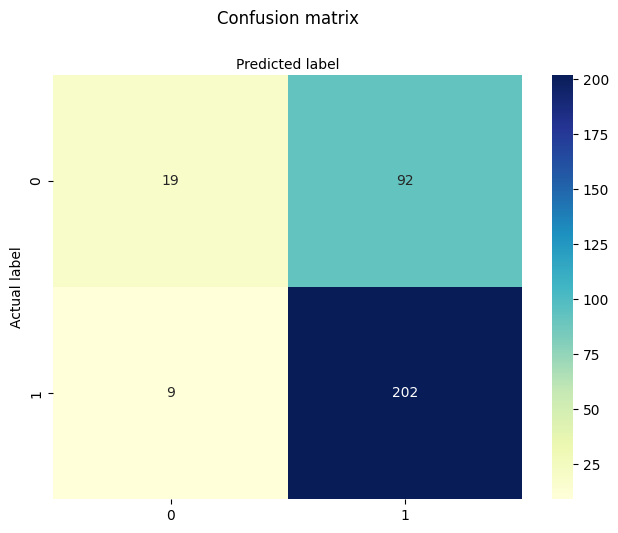

In [13]:

# Convert predicted probabilities to binary predictions
y_pred_binary = (y_pred >= 0.5).astype(int)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print("Accuracy: {:.2f}".format(accuracy))
# Evaluate the recall of the model
recall = recall_score(y_test, y_pred_binary)
print("Recall: {:.2f}".format(recall))

# Evaluate the precision of the model
precision = precision_score(y_test, y_pred_binary)
print("Precision: {:.2f}".format(precision))

# Calculate the confusion matrix of the model
cnf_matrix = confusion_matrix(y_test, y_pred_binary)


class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Optimal threshold: 0.60


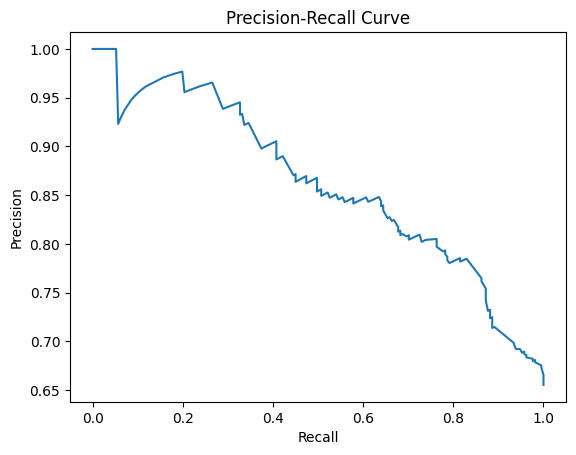

In [14]:
from sklearn.metrics import precision_recall_curve, f1_score

# Calculate precision and recall for different thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

# Calculate the F1 score for each threshold
f1_scores = [f1_score(y_test, (y_pred >= t).astype(int)) for t in thresholds]

# Find the threshold that maximizes the F1 score
optimal_threshold = thresholds[np.argmax(f1_scores)]

print(f'Optimal threshold: {optimal_threshold:.2f}')


# Plot the precision-recall curve
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

A precision-recall curve shows the trade-off between precision and recall for different thresholds. Precision is the proportion of true positive predictions among all positive predictions, while recall is the proportion of true positive predictions among all actual positive instances.

Accuracy: 0.74
Recall: 0.83
Precision: 0.78


Text(0.5, 427.9555555555555, 'Predicted label')

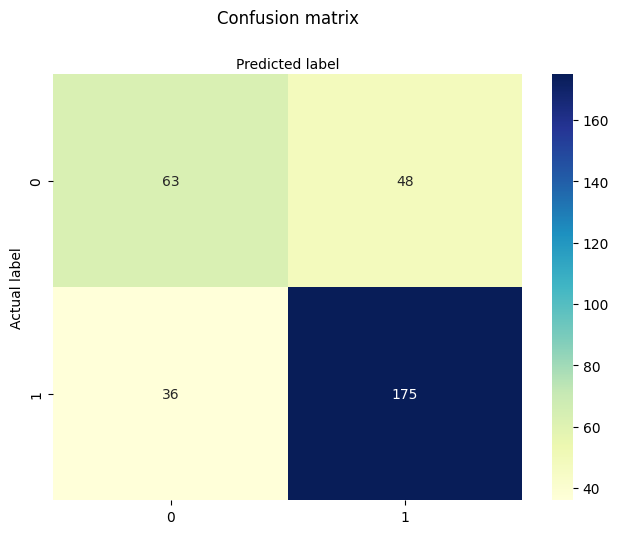

In [15]:
# Convert predicted probabilities to binary predictions
y_pred_binary = (y_pred >= 0.6).astype(int)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print("Accuracy: {:.2f}".format(accuracy))
# Evaluate the recall of the model
recall = recall_score(y_test, y_pred_binary)
print("Recall: {:.2f}".format(recall))

# Evaluate the precision of the model
precision = precision_score(y_test, y_pred_binary)
print("Precision: {:.2f}".format(precision))

# Calculate the confusion matrix of the model
cnf_matrix = confusion_matrix(y_test, y_pred_binary)


class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

## Evaluation Methods

- Precision-Recall Trade-off
- Cost-sensitive thresholding: If the costs of false positives and false negatives are different
- Balanced accuracy: Balanced accuracy is the average sensivity (true positive rate) and specificity (true negative rate)
- Cohen’s kappa: Cohen’s kappa is a measure of inter-rater agreement that takes into account the agreement that would be expected by chance. 

### Precion-Recall Trade-off

### Balanced Accuracy

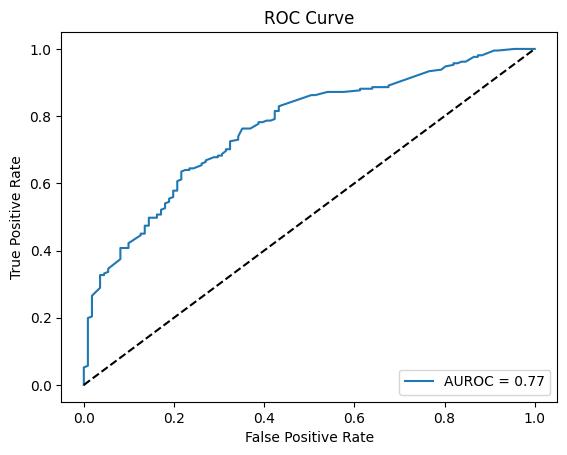

In [23]:
from sklearn.metrics import roc_curve, auc

# Calculate the false positive rate and true positive rate for different thresholds
fpr, tpr, _ = roc_curve(y_test, y_pred)

# Calculate the AUROC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label='AUROC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

The Area Under the Receiver Operating Characteristic Curve (AUROC) is a measure of how well a binary classifier can distinguish between two classes. It ranges from 0 to 1, with 1 indicating perfect classification and 0.5 indicating random guessing.

In [17]:
# Calculate the confusion matrix for each threshold
cms = [confusion_matrix(y_test, (y_pred >= t).astype(int)) for t in thresholds]

# Calculate sensitivity and specificity for each threshold
sensitivity = [cm[1, 1] / (cm[1, 1] + cm[1, 0]) for cm in cms]
specificity = [cm[0, 0] / (cm[0, 0] + cm[0, 1]) for cm in cms]

# Calculate balanced accuracy for each threshold
balanced_accuracy = [(s + sp) / 2 for s, sp in zip(sensitivity, specificity)]

# Find the threshold that maximizes balanced accuracy
optimal_threshold = thresholds[np.argmax(balanced_accuracy)]

print(f'Optimal threshold: {optimal_threshold:.2f}')

Optimal threshold: 0.76


Accuracy: 0.68
Recall: 0.62
Precision: 0.85


Text(0.5, 427.9555555555555, 'Predicted label')

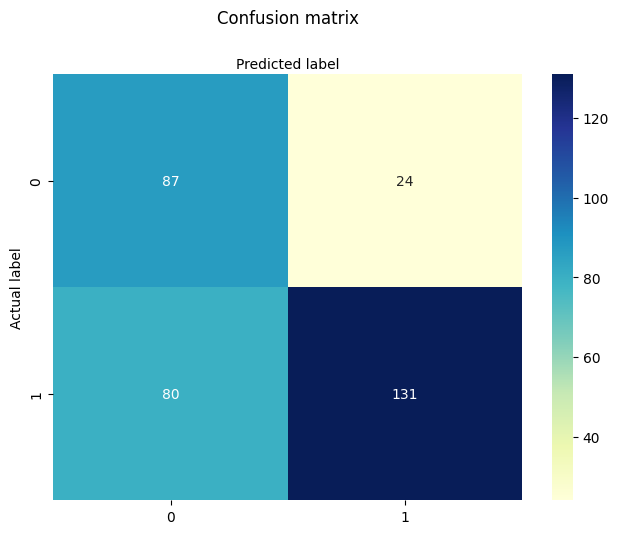

In [18]:
# Convert predicted probabilities to binary predictions
y_pred_binary = (y_pred >= 0.76).astype(int)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print("Accuracy: {:.2f}".format(accuracy))
# Evaluate the recall of the model
recall = recall_score(y_test, y_pred_binary)
print("Recall: {:.2f}".format(recall))

# Evaluate the precision of the model
precision = precision_score(y_test, y_pred_binary)
print("Precision: {:.2f}".format(precision))

# Calculate the confusion matrix of the model
cnf_matrix = confusion_matrix(y_test, y_pred_binary)


class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

### Cohen's Kappa


Cohen’s kappa is a measure of inter-rater agreement that takes into account the agreement that would be expected by chance. It is commonly used to evaluate the agreement between two raters or between a model’s predictions and the true values.

Cohen’s kappa ranges from -1 to 1. A value of 1 indicates perfect agreement between the raters or between the model’s predictions and the true values. A value of 0 indicates that the agreement is no better than what would be expected by chance. A negative value indicates that the agreement is worse than what would be expected by chance.

In [19]:
from sklearn.metrics import cohen_kappa_score

# Calculate Cohen's kappa for each threshold
kappas = [cohen_kappa_score(y_test, (y_pred >= t).astype(int)) for t in thresholds]

# Find the threshold that maximizes Cohen's kappa
optimal_threshold = thresholds[np.argmax(kappas)]

print(f'Optimal threshold: {optimal_threshold:.2f}')

Optimal threshold: 0.60


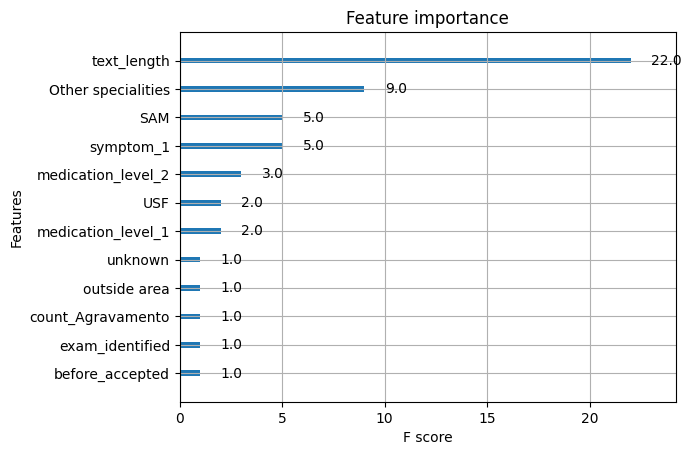

In [24]:
from xgboost import plot_importance

# Plot the feature importance scores
plot_importance(model_score)
plt.show()

## Trying other hyperparemeters

In [34]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from xgboost import XGBClassifier


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=16,shuffle=False)

X_train_encoded = pd.concat([X_train.drop('before_accepted', axis=1), pd.get_dummies(X_train['before_accepted'])], axis=1)
X_test_encoded = pd.concat([X_test.drop('before_accepted', axis=1), pd.get_dummies(X_test['before_accepted'])], axis=1)

# Define the hyperparameter grid
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 300]
}

# Create an XGBoost classifier
model = XGBClassifier()

# Create a grid search object
grid_search = GridSearchCV(model, param_grid, cv=5)

# Fit the grid search object to the encoded data
grid_search.fit(X_train_encoded, y_train)

# Print the best hyperparameters
print('Best hyperparameters:', grid_search.best_params_)

Best hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


In [37]:
def xgb_classifier_new(features, target):
    # split X and y into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2,random_state=16,shuffle=False)

    X_train['before_accepted'] = X_train['before_accepted'].astype('category')
    X_test['before_accepted'] = X_test['before_accepted'].astype('category')

    # Convert data into DMatrix format
    dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical = True)
    dtest = xgb.DMatrix(X_test, enable_categorical = True)

    # Set parameters for the XGBoost model
    param = {
        'max_depth': 3,
        'eta': 0.01,
        'objective': 'binary:logistic',
        'seed': 16
    }

    # Train the model
    num_round = 200
    bst = xgb.train(param, dtrain, num_round)

    # Make predictions on the test set
    y_pred = bst.predict(dtest)
    
    return y_pred, bst.get_score(), X_train, X_test, y_train, y_test  


y_pred, model_score, X_train, X_test, y_train, y_test = xgb_classifier_new(X,y)

Accuracy: 0.69
Recall: 0.95
Precision: 0.69


Text(0.5, 427.9555555555555, 'Predicted label')

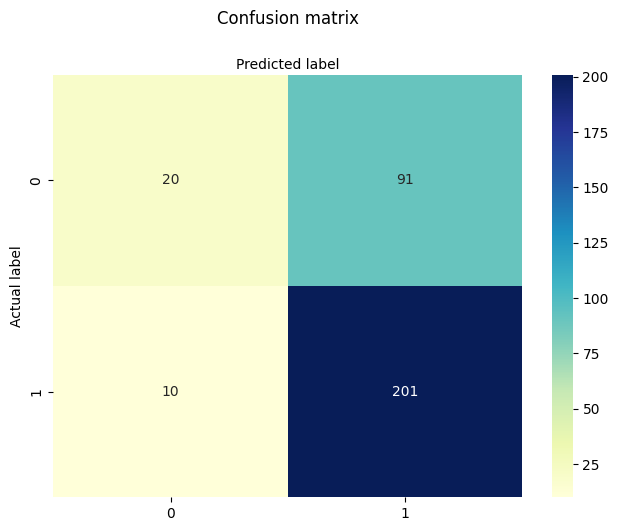

In [38]:

# Convert predicted probabilities to binary predictions
y_pred_binary = (y_pred >= 0.5).astype(int)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print("Accuracy: {:.2f}".format(accuracy))
# Evaluate the recall of the model
recall = recall_score(y_test, y_pred_binary)
print("Recall: {:.2f}".format(recall))

# Evaluate the precision of the model
precision = precision_score(y_test, y_pred_binary)
print("Precision: {:.2f}".format(precision))

# Calculate the confusion matrix of the model
cnf_matrix = confusion_matrix(y_test, y_pred_binary)


class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Optimal threshold: 0.58


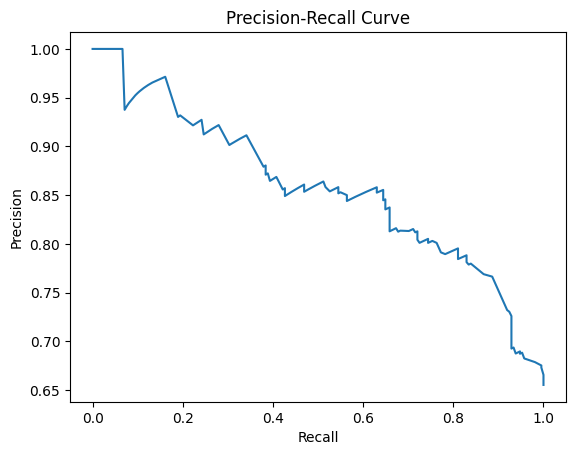

In [39]:
from sklearn.metrics import precision_recall_curve, f1_score

# Calculate precision and recall for different thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

# Calculate the F1 score for each threshold
f1_scores = [f1_score(y_test, (y_pred >= t).astype(int)) for t in thresholds]

# Find the threshold that maximizes the F1 score
optimal_threshold = thresholds[np.argmax(f1_scores)]

print(f'Optimal threshold: {optimal_threshold:.2f}')


# Plot the precision-recall curve
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

Accuracy: 0.74
Recall: 0.87
Precision: 0.77


Text(0.5, 427.9555555555555, 'Predicted label')

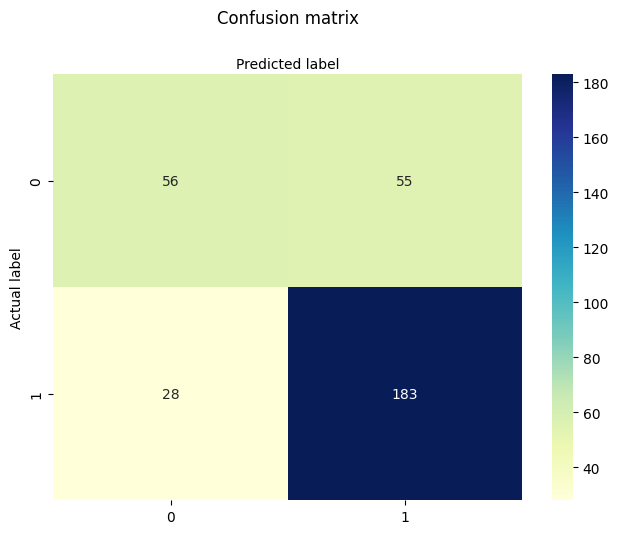

In [40]:
# Convert predicted probabilities to binary predictions
y_pred_binary = (y_pred >= 0.58).astype(int)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print("Accuracy: {:.2f}".format(accuracy))
# Evaluate the recall of the model
recall = recall_score(y_test, y_pred_binary)
print("Recall: {:.2f}".format(recall))

# Evaluate the precision of the model
precision = precision_score(y_test, y_pred_binary)
print("Precision: {:.2f}".format(precision))

# Calculate the confusion matrix of the model
cnf_matrix = confusion_matrix(y_test, y_pred_binary)


class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

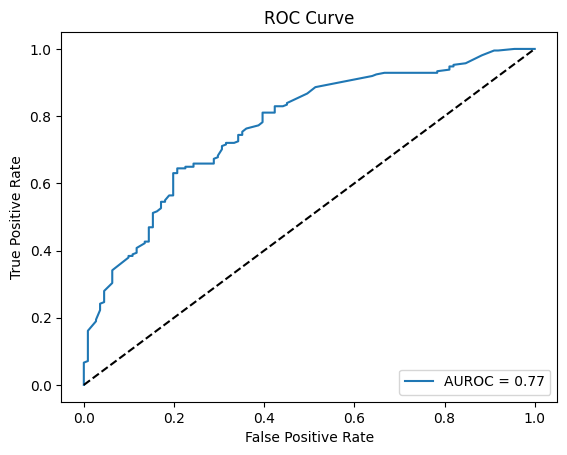

In [41]:
from sklearn.metrics import roc_curve, auc

# Calculate the false positive rate and true positive rate for different thresholds
fpr, tpr, _ = roc_curve(y_test, y_pred)

# Calculate the AUROC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label='AUROC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [42]:
# Calculate the confusion matrix for each threshold
cms = [confusion_matrix(y_test, (y_pred >= t).astype(int)) for t in thresholds]

# Calculate sensitivity and specificity for each threshold
sensitivity = [cm[1, 1] / (cm[1, 1] + cm[1, 0]) for cm in cms]
specificity = [cm[0, 0] / (cm[0, 0] + cm[0, 1]) for cm in cms]

# Calculate balanced accuracy for each threshold
balanced_accuracy = [(s + sp) / 2 for s, sp in zip(sensitivity, specificity)]

# Find the threshold that maximizes balanced accuracy
optimal_threshold = thresholds[np.argmax(balanced_accuracy)]

print(f'Optimal threshold: {optimal_threshold:.2f}')

Optimal threshold: 0.71


Accuracy: 0.69
Recall: 0.64
Precision: 0.85


Text(0.5, 427.9555555555555, 'Predicted label')

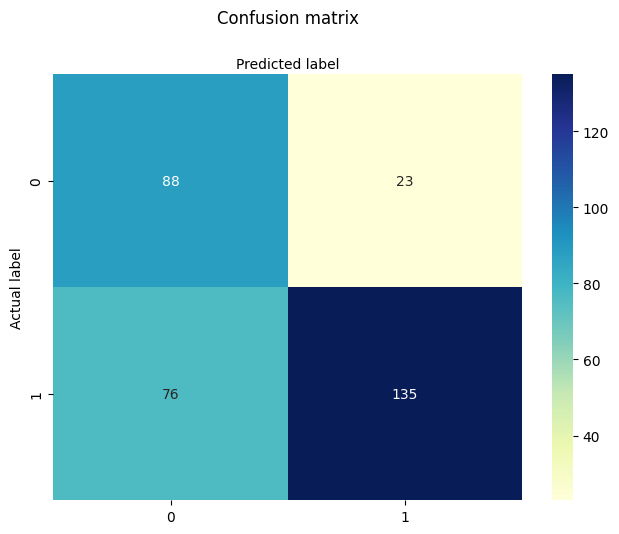

In [43]:
# Convert predicted probabilities to binary predictions
y_pred_binary = (y_pred >= 0.71).astype(int)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print("Accuracy: {:.2f}".format(accuracy))
# Evaluate the recall of the model
recall = recall_score(y_test, y_pred_binary)
print("Recall: {:.2f}".format(recall))

# Evaluate the precision of the model
precision = precision_score(y_test, y_pred_binary)
print("Precision: {:.2f}".format(precision))

# Calculate the confusion matrix of the model
cnf_matrix = confusion_matrix(y_test, y_pred_binary)


class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [44]:
from sklearn.metrics import cohen_kappa_score

# Calculate Cohen's kappa for each threshold
kappas = [cohen_kappa_score(y_test, (y_pred >= t).astype(int)) for t in thresholds]

# Find the threshold that maximizes Cohen's kappa
optimal_threshold = thresholds[np.argmax(kappas)]

print(f'Optimal threshold: {optimal_threshold:.2f}')

Optimal threshold: 0.63


Accuracy: 0.73
Recall: 0.80
Precision: 0.79


Text(0.5, 427.9555555555555, 'Predicted label')

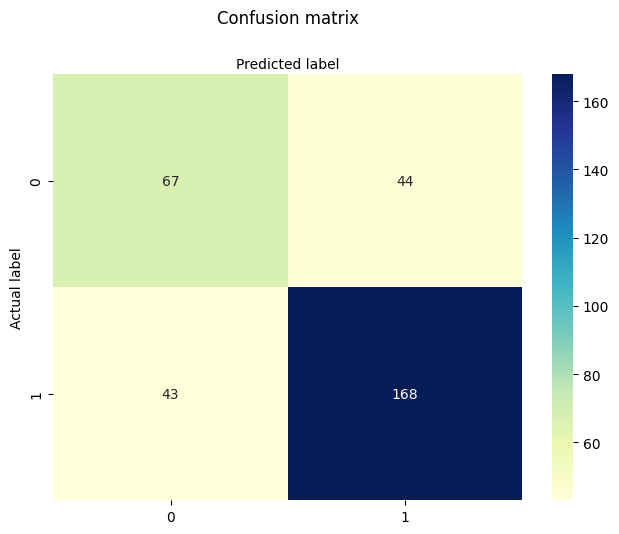

In [45]:
# Convert predicted probabilities to binary predictions
y_pred_binary = (y_pred >= 0.63).astype(int)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print("Accuracy: {:.2f}".format(accuracy))
# Evaluate the recall of the model
recall = recall_score(y_test, y_pred_binary)
print("Recall: {:.2f}".format(recall))

# Evaluate the precision of the model
precision = precision_score(y_test, y_pred_binary)
print("Precision: {:.2f}".format(precision))

# Calculate the confusion matrix of the model
cnf_matrix = confusion_matrix(y_test, y_pred_binary)


class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

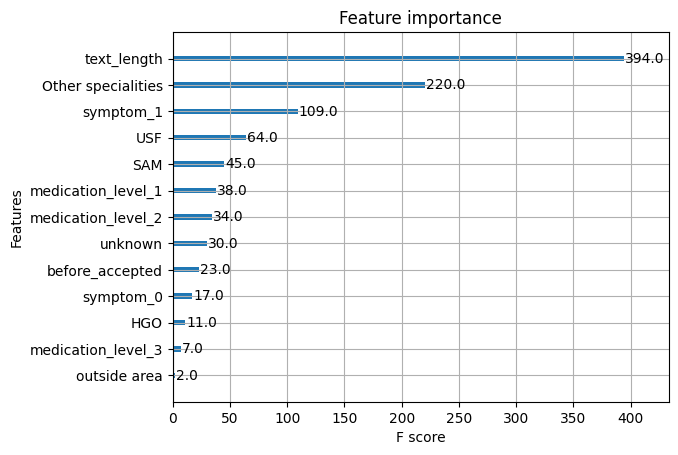

In [46]:
from xgboost import plot_importance

# Plot the feature importance scores
plot_importance(model_score)
plt.show()